In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Sieci Neuronowe I

## Pochodne

Czym jest pochodna? Zdefiniujmy dowolną funkcję $f(x)$

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

Narysujmy wykres funkcji $f(x)$

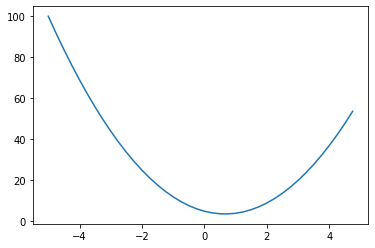

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

Możemy wyznaczyć wzór na pochodną powyższej funkcji analitycznie. W praktyce nikt jednak nie wyznacza ręcznie wzorów na pochodne, które mogą być niezwykle skomplikowane.
Przypomnijmy definicję pochodnej (a konkretniej warunku różniczkowalności):
$$L = \mathop {\lim }\limits_{h \to 0} \frac{{f\left( {x + h } \right) - f\left( x \right)}}{h }$$
Innymi słowy, jak zmieni się wartość funkcji ($f(x)$), jeżeli podniesiemy wartość $x$ o $h$ (jak wrażliwa jest wartość funkcji na tę zmianę, jakie jest nachylenie stycznej w punkcie $x$). Czy wartość funkcji wzrośnie, czy zmaleje? Jak duża będzie ta zmiana?

Wyznaczmy wartość pochodnej numerycznie. Otrzymane wartości będą jedynie przybliżeniami, im $h$ bliższe $0$, tym lepsza aproksymacja.


In [4]:
h = 0.0001
x = 3.0
f(x) # 20
f(x + h) # wartość wzrośnie czy zmaleje?
f(x + h) - f(x) # jak duża była to zmiana?
(f(x + h) - f(x))/h # normalizując wzrost przez krok otrzymujemy wartość nachylenia

14.000300000063248

##### I - pytania o różne wartości pochodnej (x=-3, x=2/3)

Rozważmy bardziej złożony przypadek. Tym razem interesuje nas, jak będzie zmieniała się wartość funkcji, kiedy będziemy zmieniać wartości zmiennych $a, b, c$. Inaczej mówiąc, interesuje nas, jaka jest pochodna $d$ w zależności od $a, b, c$?

In [5]:
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1 = ', d1)
# print('d2 = ', d2)
# print('Nachylenie stycznej: ', (d2-d1)/h)

d1 =  4.0


##### I - co się stanie z wartością d2? Jaki będzie znak nachylenia stycznej?

## Autograd
[Autograd tutorial](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)
[Autograd mechanics](https://pytorch.org/docs/stable/notes/autograd.html#:~:text=Autograd%20is%20reverse%20automatic%20differentiation,roots%20are%20the%20output%20tensors.)

### Graf obliczeń


In [49]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0  # brak zmian, początkowo zmienna nie wpływa na funkcję straty
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    # definicja operatora '+', a.__add__ == +
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [7]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

### Wizualizacja grafu obliczeń

Wierzchołkami reprezentującymi wartości są jedynie węzły w prostokątach. Łączące je okrągłe wierzchołki są jedynie wizualizacją wykonanej operacji.

In [8]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

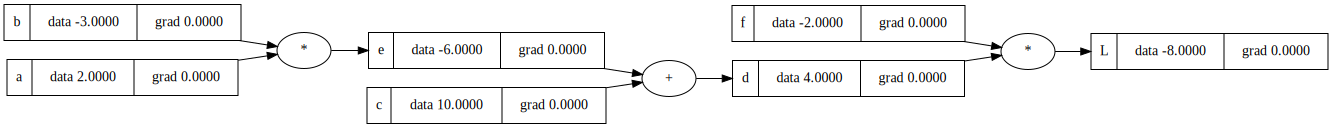

In [9]:
draw_dot(L)

### Propagacja wsteczna

W kontekście sieci neuronowych interesuje nas pochodna funkcji straty ($L$) w zależności od każdej ze zmiennych zawartych w grafie obliczeniowym, które będziemy nazywali *wagami* sieci. Użyjemy wartości gradientów do aktualizacji wartości funkcji straty.
Każdy gradient w grafie obliczeń reprezentuje pochodną wartości wyjściowej w zależności od wartości, do której jest przypisany.

#### Przykład
$L=d*f$

* $\frac{\mathrm{d}L}{\mathrm{d}L} = 1$
* $\frac{\mathrm{d}L}{\mathrm{d}d} = \frac{\mathrm{d}}{\mathrm{d}d}d*f = f$
* $\frac{\mathrm{d}L}{\mathrm{d}f} = \frac{\mathrm{d}}{\mathrm{d}f}d*f = d$

In [10]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0

#### [Reguła łańcuchowa](https://pl.wikipedia.org/wiki/Regu%C5%82a_%C5%82a%C5%84cuchowa)
Jak wyznaczyć $\frac{\mathrm{d}L}{\mathrm{d}c} = ?$. Aby to zrobić, należy skorzystać z *reguły łańcuchowej*. Jeżeli znamy wpływ, jaki ma na zmienną $L$ zmienna $d$ (czyt. znamy $\frac{\mathrm{d}L}{\mathrm{d}d}$), oraz znamy wpływ, jaki na zmienną $d$ ma zmienna $c$ (znamy $\frac{\mathrm{d}d}{\mathrm{d}c}$), możemy użyć tych informacji do wyznaczenia $\frac{\mathrm{d}L}{\mathrm{d}c}$. $d = c + e$, stąd $\frac{\mathrm{d}d}{\mathrm{d}c}=1$ (analogicznie, $\frac{\mathrm{d}d}{\mathrm{d}e}=1$).

$\frac{\mathrm{d}L}{\mathrm{d}c} = \frac{\mathrm{d}L}{\mathrm{d}d} * \frac{\mathrm{d}d}{\mathrm{d}c} = -2 * 1 = -2$.
$\frac{\mathrm{d}L}{\mathrm{d}e} = -2$

Węzły z operacją dodawania lokalnie "przenoszą" wartości gradientów.

In [11]:
c.grad = -2
e.grad = -2

Aby wyznaczyć wartości gradientów dla węzłów $a$ i $b$, również zastosujemy regułę łańcuchową.
$e = a*b, \frac{\mathrm{d}e}{\mathrm{d}a} = -3, \frac{\mathrm{d}e}{\mathrm{d}b} = 2$
$\frac{\mathrm{d}L}{\mathrm{d}a} = \frac{\mathrm{d}L}{\mathrm{d}e} * \frac{\mathrm{d}e}{\mathrm{d}a} = -2 * -3 = 6$
$\frac{\mathrm{d}L}{\mathrm{d}b} = \frac{\mathrm{d}L}{\mathrm{d}e} * \frac{\mathrm{d}e}{\mathrm{d}b} = -2 * 2 = -4$

Tak otrzymujemy wypełniony graf obliczeń.

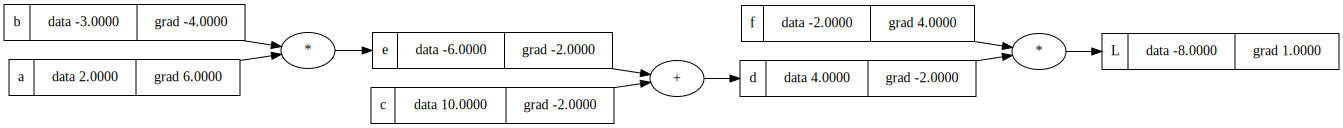

In [12]:
a.grad = 6
b.grad = -4
draw_dot(L)

Podsumowując, propagacja wsteczna jest rekurencyjną aplikacją reguły łańcuchowej poruszając się wstecz przez graf obliczeniowy.

Jak użyć wyznaczonych wartości? Spróbujmy podnieść wartość $L$. Oznacza to, że musimy zwiększać wartości zmiennych wpływających na $L$ w kierunku gradientów!

Jest to pojedynczy krok algorytmu optymalizacyjnego propagacji wstecznej sieci neuronowych.

In [13]:
h = 0.001  #krok
a.data += h * a.grad
b.data += h * b.grad
c.data += h * c.grad
f.data += h * f.grad

e = a * b
d = e + c
L = d * f
L

Value(data=-7.928064095999999)

### Neuron

Neuron otrzymuje na wejściu dane ($x_{i}$). Przechodzą one przez synapsy, gdzie każda z nich posiada przypisaną wagę ($w_{i}$). Do "komórki" wpada iloczyn danej wejściowej oraz wagi synapsy ($x_{i}w_{i}$). Danych wejściowych może być wiele, stąd neuron sumuje wszystkie iloczyny, dodaje 'bias', który niezależnie od danych wejściowych może podnieść lub obniżyć wartość wyjściową komórki. Na końcu neuron dokonuje *aktywacji* poprzez *funkcję aktywacji*. Funkcja ta "zgniata" (ang. *squashing*) wartość sumy do pewnego zakresu liczbowego. Na przykład funkcja *softmax* przyjmuje na wejściu wartość rzeczywistą, a na wyjściu zwraca wartość z zakresu $[0,1]$. Innym przykładem funkcji aktywacji jest $tanh$.


![](img/neuron_model.jpeg)

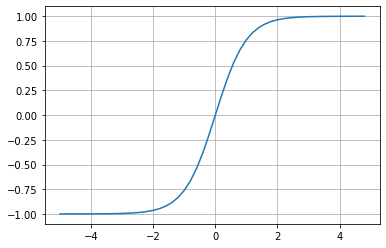

In [14]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

Wartości wejściowe do funkcji $tanh$ są "zgniatane" to wartości z zakresu $[-1,1]$. Warto zwrócić uwagę, że wartości $(-\infty,-2)$ otrzymają wartości bliskie $-1$, natomiast od $(2, \infty)$ wartość $1$.

Do tej pory klasa Value potrafi jedynie wykonywać działania $+$ oraz $*$. Teraz chcemy użyć funkcji $tanh$, więc klasa ta powinna wspierać taką operację. Wzór na $tanh$:

$$tanh(x) = \frac{e^{2x}-1}{e^{2x}+1}$$

Aby klasa Value wspierała funkcję $tanh$ możemy:
* dodać możliwość wykonywania działania $exp$ oraz wyznaczyć wartość $tanh$ z atomowych komponentów w ramach grafu obliczeniowego
* wyznaczyć $tanh$ bezpośrednio jako pojedynczy węzeł grafu

Budując autograd, możemy tworzyć funkcje na dowolnym poziomie abstrakcji (skomplikowania). Najważniejsze jest, aby móc wyznaczyć lokalną pochodną dla każdej z użytych funkcji w grafie obliczeniowym.

In [59]:
# wartości wejściowe
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# wagi
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias neuronu
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
# wartość sumy
n = x1w1x2w2 + b; n.label = 'n'
# aktywacja
o = n.tanh(); o.label = 'o'

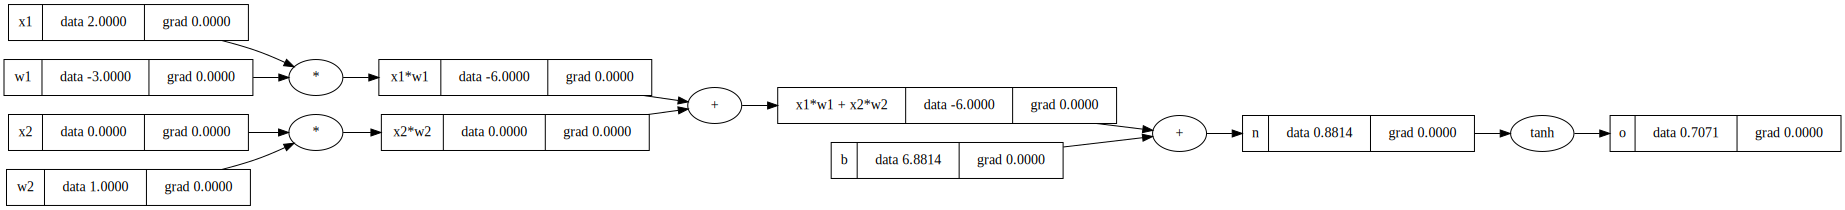

In [27]:
draw_dot(o)

Wyjściem z neuronu jest wartość $0.7071$. Następnym krokiem w algorytmie propagacji wstecznej jest wyznaczenie gradientów. Jakie są wartości pochodnych $o$ względem wszystkich wartości wejściowych (głównie chodzi nam o wagi $w$)?

Wyznaczmy lokalne gradienty grafu obliczeniowego:
* $\frac{\mathrm{d}}{\mathrm{d}o}o = 1.0$
* $\frac{\mathrm{d}o}{\mathrm{d}n} = \frac{\mathrm{d}}{\mathrm{d}n}tanh(n) = 1-tanh(n)^{2} = 1-o^{2}$

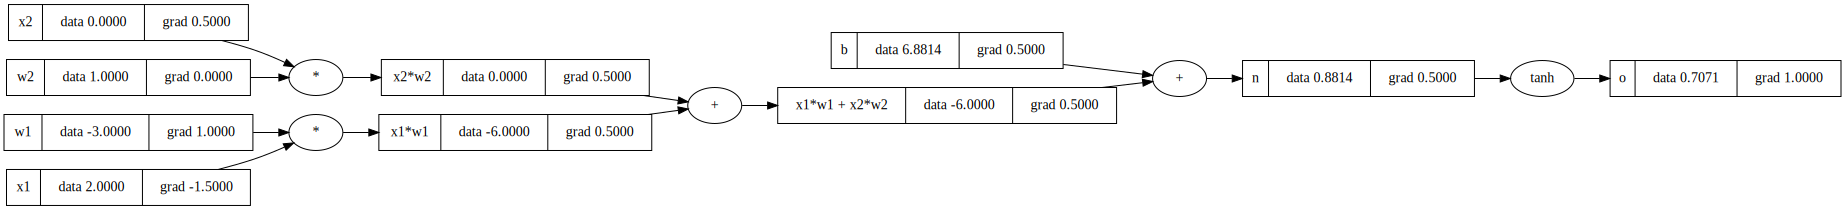

In [35]:
o.grad = 1.0
n.grad = 1 - o.data**2
# węzły 'dodawania' przenoszą gradient
b.grad = n.grad
x1w1x2w2.grad = n.grad
x2w2.grad = x1w1x2w2.grad
x1w1.grad = x1w1x2w2.grad
# węzły 'mnożenia' (reguła łańcuchowa)
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad  # zmiana tej wagi nie powoduje zmiany wartości wyjściowej, gdyż x2 = 0!
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

draw_dot(o)

### Automatyzacja

Do klasy *Value* dodamy atrybut *_backward*, który przechowuje "domknięcie" (ang. *closure*), która wyznacza lokalną pochodną konkretnej operacji.

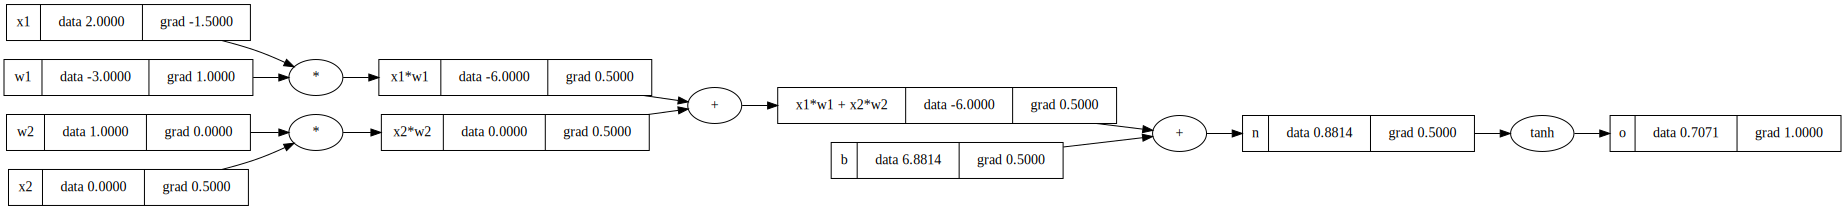

In [51]:
o.grad = 1.0 # Początkowa wartość gradientu w węźle wyjściowym jest równa 0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o)

Ostatnim krokiem jest wykonanie wszystkich operacji *backward*, przechodząc po grafie wstecz. Algorytm, który do tego wykorzystamy to [sortowanie topologiczne](https://pl.wikipedia.org/wiki/Sortowanie_topologiczne) (ang. *topological sort*)

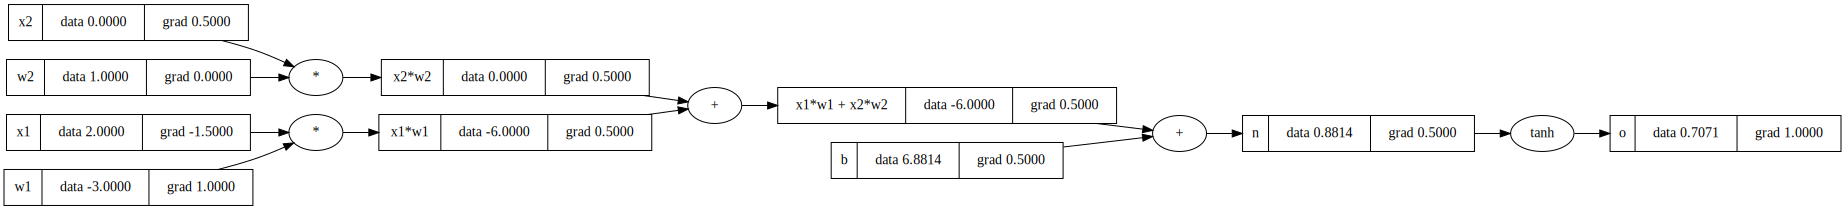

In [63]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

o.grad = 1.0
for node in reversed(topo):
    node._backward()
draw_dot(o)

Po dodaniu tej metody do klasy *Value* jedyne co musimy wykonać to *backward* na ostatnim węźle grafu obliczeniowego.

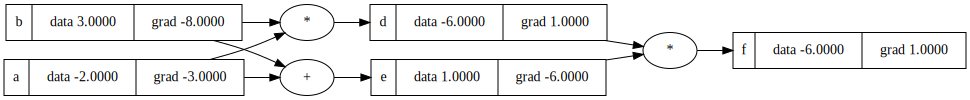

In [61]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

### PyTorch

W praktyce do trenowania sieci neuronowych wykorzystujemy biblioteki, które implementują silniki automatycznego różniczkowania (ang. *automatic differentiation engine*).

PyTorch opiera się na obliczeniach na *tensorach* (w powyższej prostej implementacji opieramy się na skalarach). Są to wielowymiarowe tablice skalarów.

In [1]:
import torch

In [2]:
# cast do typu double, aby ujednolicić typu (Python korzysta z double z default'u, natomiast PyTorch korzysta z typu float32)

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
# powyższe zmienne są liśćmi grafu obliczeniowego i PyTorch z default'u nie wyznacza im gradientów (stąd  x1.requires_grad = True)
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## Materiały

* [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0)
* [PyTorch 101, Part 1: Understanding Graphs, Automatic Differentiation and Autograd](https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/)